# CS410 - Fake News Classifier Training Notebook

## loading the libs

In [11]:
import os
import re
import sys
import numpy as np
from scipy.sparse import hstack
import time
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import lightgbm as lgb
import wordbatch
from wordbatch.extractors import WordBag, WordHash
from nltk.corpus import stopwords
import pickle as pkl
import gzip
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

## Defining some helper functions for normalize the texts

In [12]:
stemmer = SnowballStemmer("english")

# Define helpers for text normalization
stopwords = {x: 1 for x in stopwords.words('english')}
non_alphanums = re.compile(u'[^A-Za-z0-9]+')

def normalize_text(text):
    return u" ".join(
        [x for x in [y for y in non_alphanums.sub(' ', text).lower().strip().split(" ")] \
         if len(x) > 1 and x not in stopwords])


## loading the data

In [13]:
train = pd.read_csv('data/df_final_v1.csv')
test = pd.read_csv('data/kaggle/test.csv')

In [14]:
train_size = train.shape[0]
y = train['label']
test_ids = test['id']
test_size = test.shape[0]
print(train.shape)
print(y.shape)
print(test_ids.shape)
print(test_size.shape)

(54394, 4)

## visualize the distribution for the train subjects

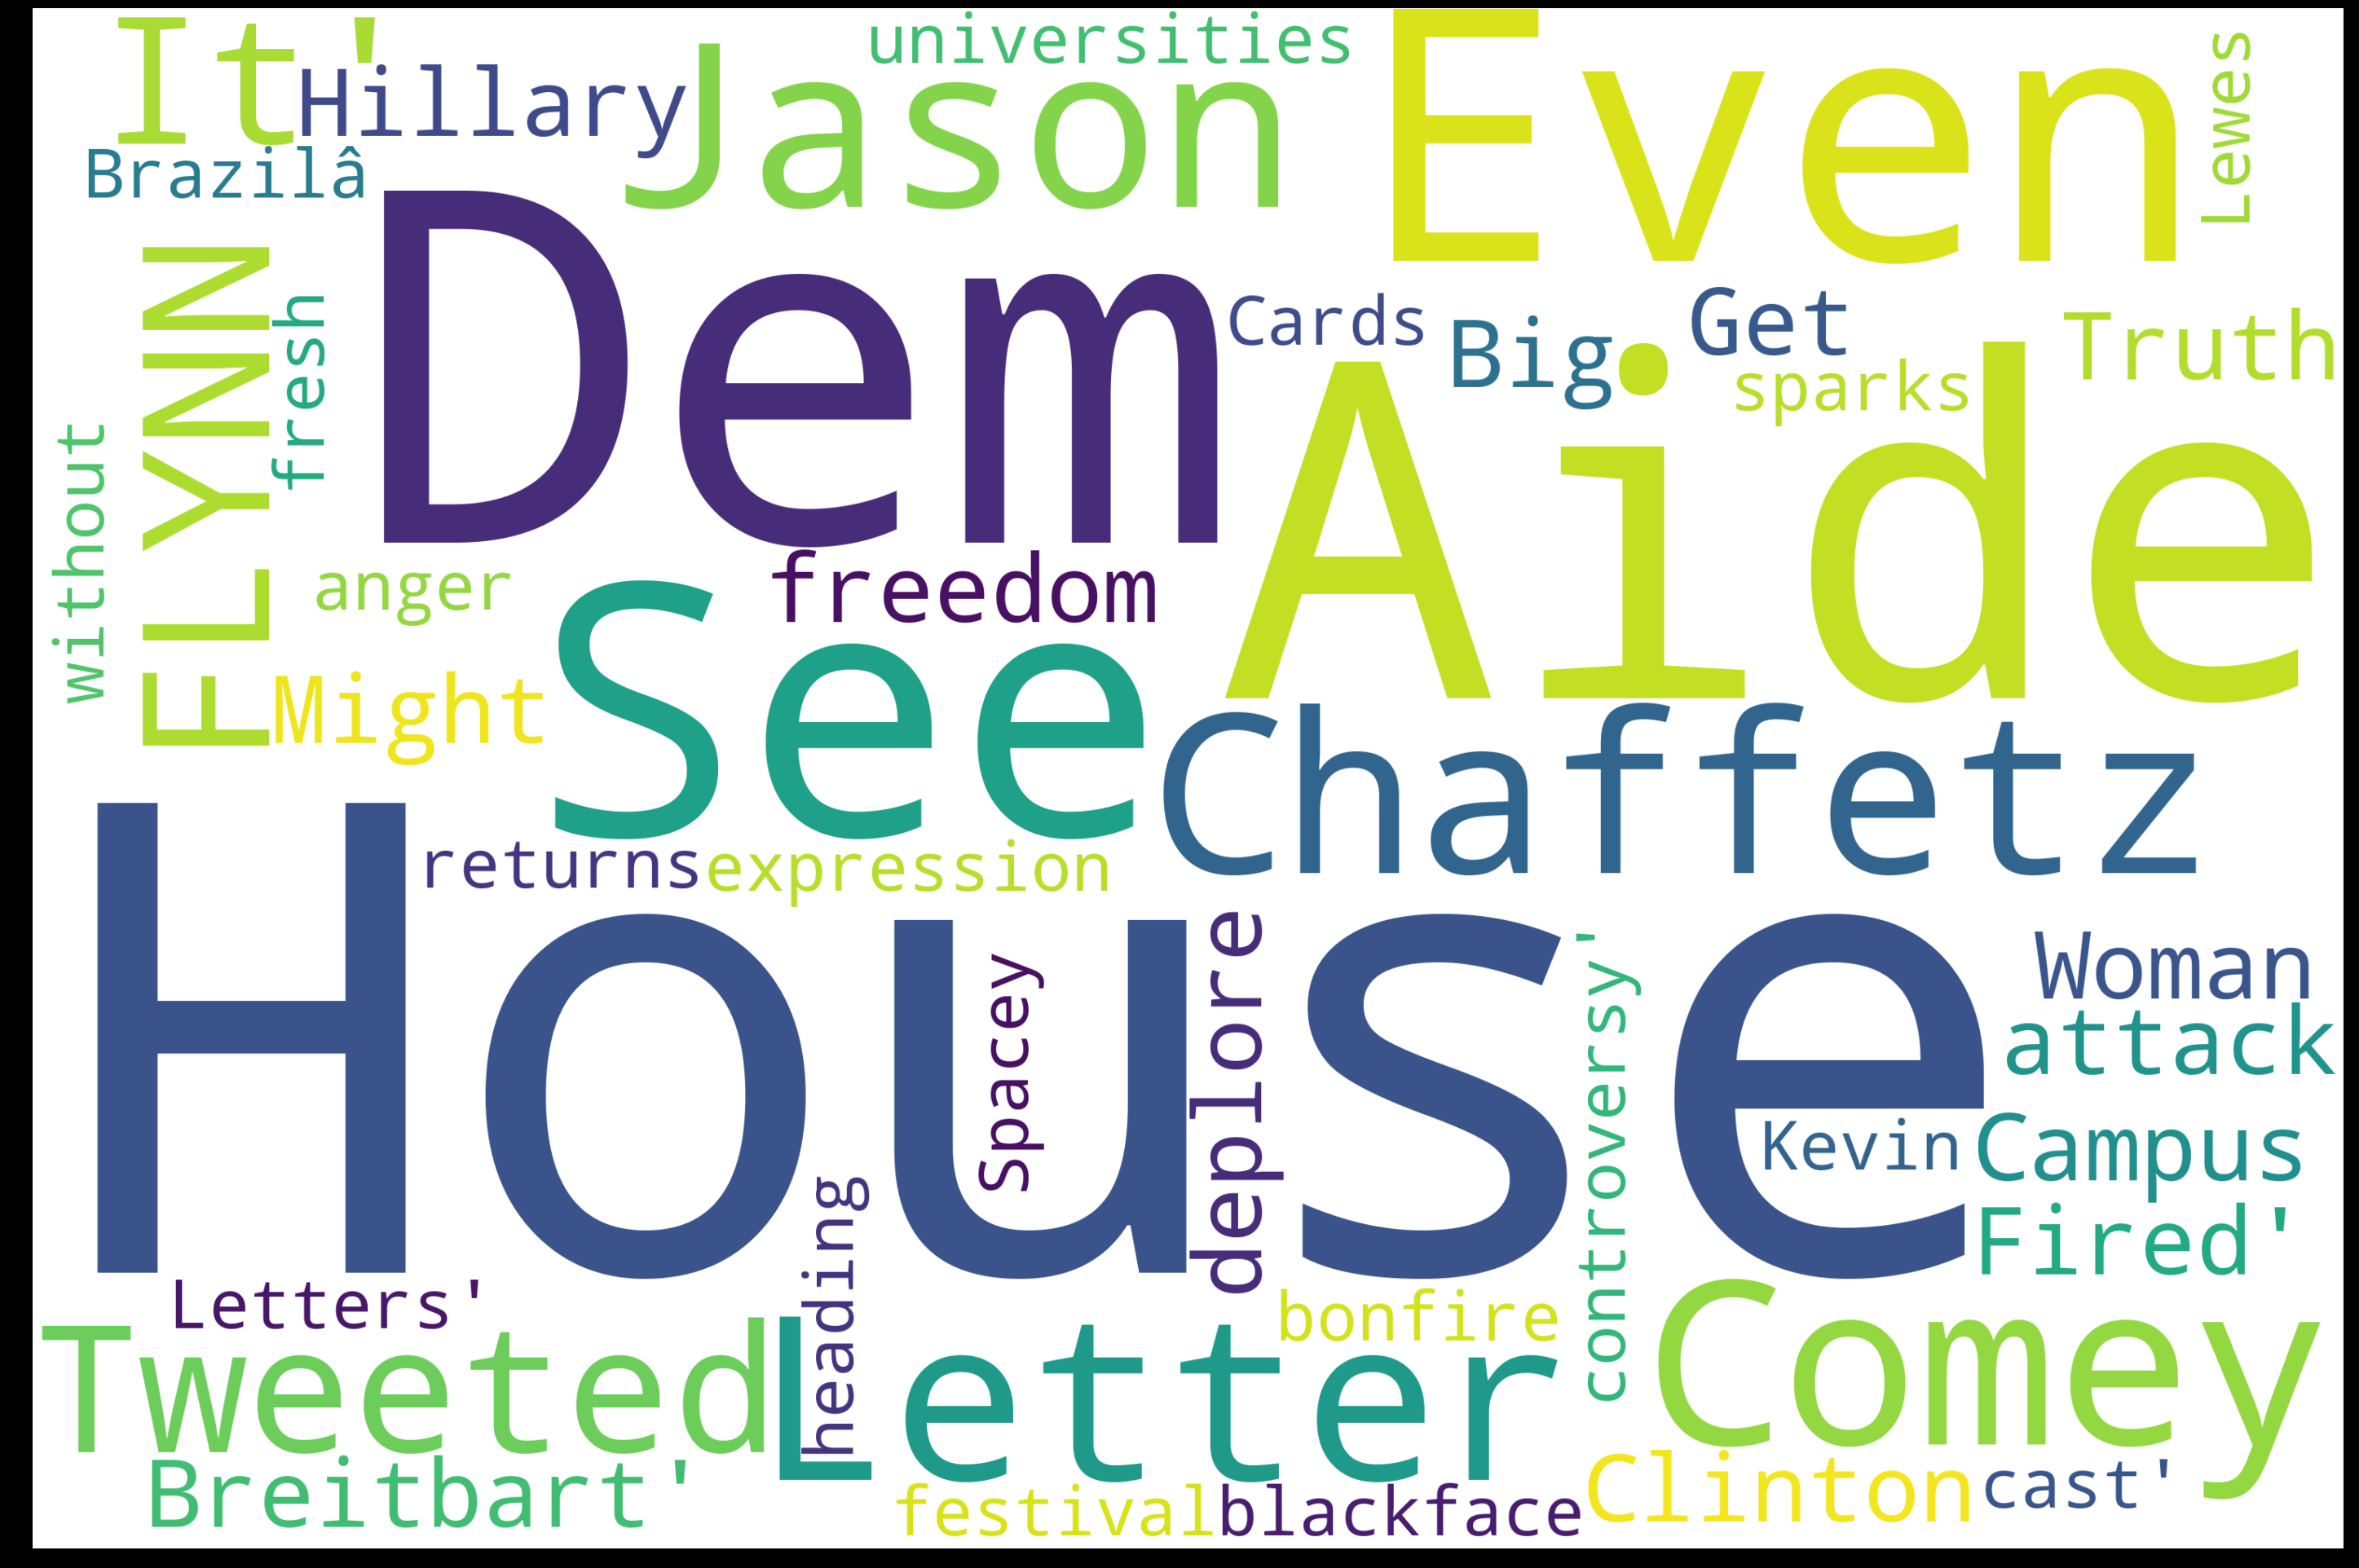

In [15]:
text = train['title'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## visualize the test distribution

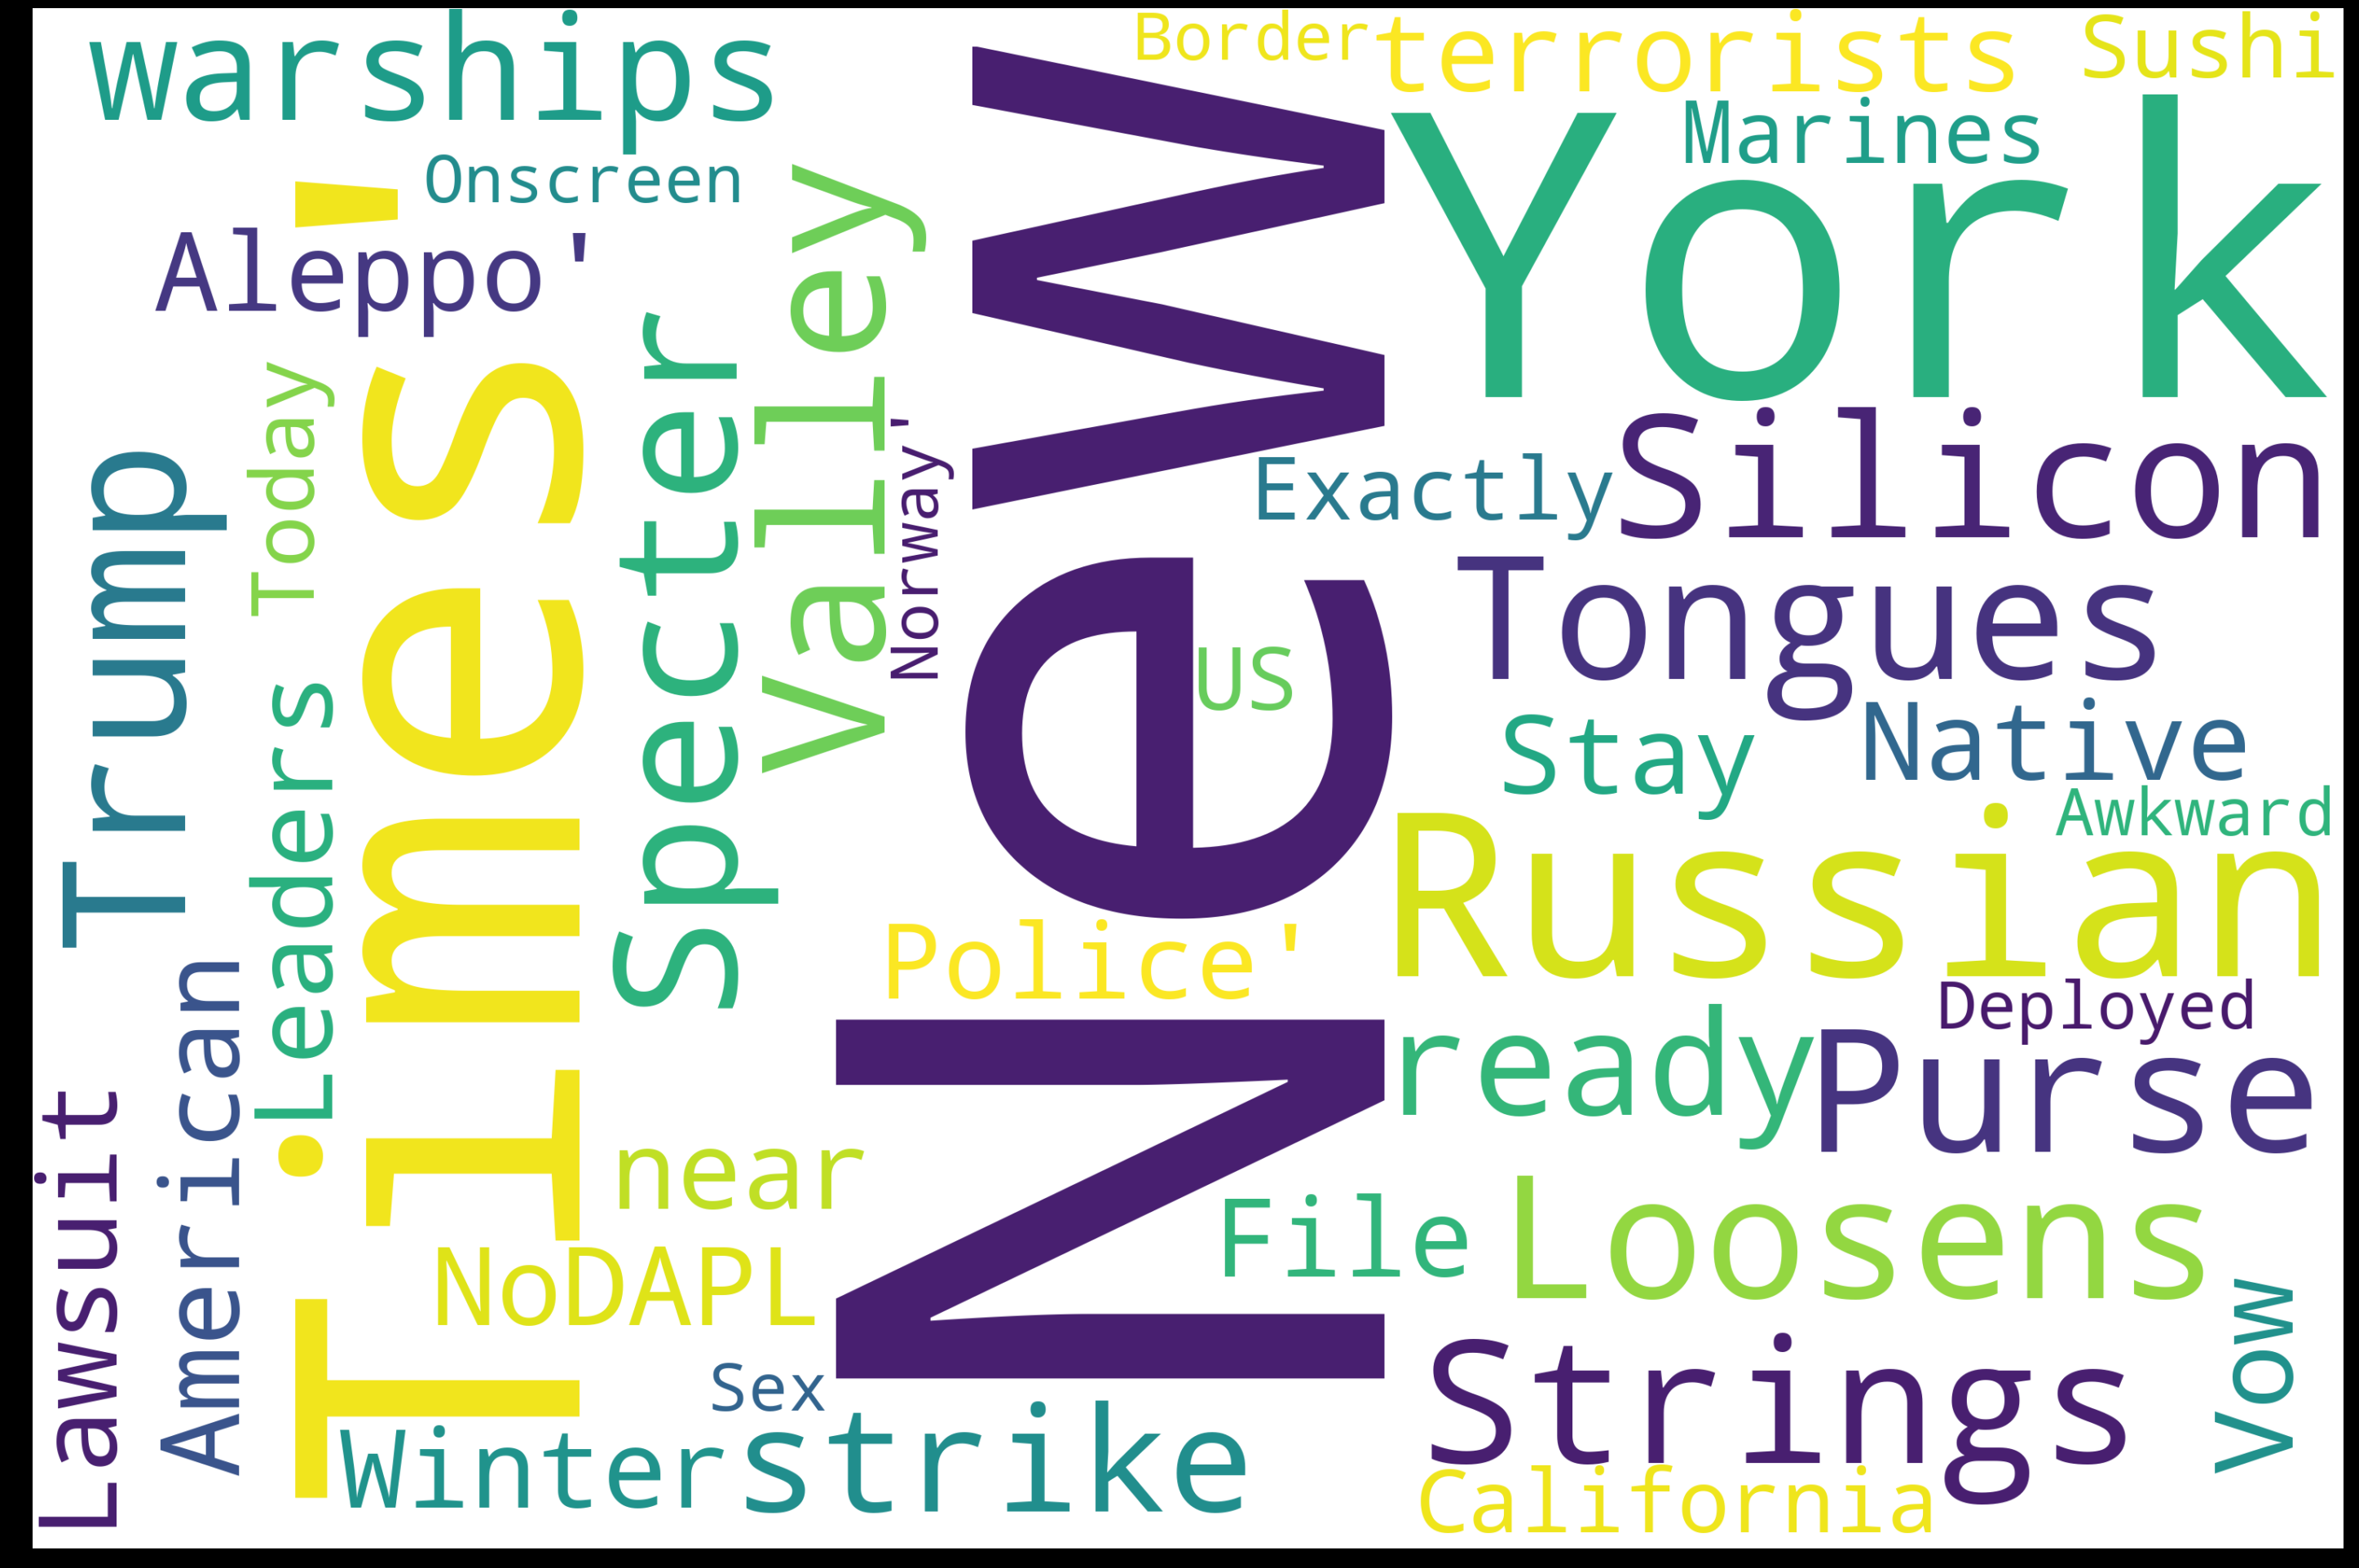

In [16]:
text = test['title'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## some cleanup

In [17]:
train.drop(['label'], axis=1, inplace=True)

In [18]:
test.drop(['id'], axis=1, inplace=True)

In [19]:
test.shape

(5200, 3)

## appending train and test for preprocessing

In [20]:
df = train.append(test, sort=False)
df.shape

(59594, 3)

In [21]:
df.head()

title              author  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  
1  Ever get the feeling your life circles the rou...  
2  Why the Truth Might Get You Fired October 29, ...  
3  Videos 15 Civilians Killed In Single US Airstr...  
4  Print \r\nAn Iranian woman has been sentenced ...

## fill nans

In [22]:
print("Filling NaNs")
df['author'].fillna('No author', inplace=True)
df['title'].fillna('No title', inplace=True)
df['text'].fillna('No text', inplace=True)

Filling NaNs


## encode author as category

In [23]:
print("Start Encoding Labels for Author")
le = LabelEncoder()
df['author_cat'] = le.fit_transform(df['author'])
df.head()

Start Encoding Labels for Author


title              author  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  author_cat  
0  House Dem Aide: We Didn’t Even See Comey’s Let...        2191  
1  Ever get the feeling your life circles the rou...        2114  
2  Why the Truth Might Get You Fired October 29, ...        1863  
3  Videos 15 Civilians Killed In Single US Airstr...        4372  
4  Print \r\nAn Iranian woman has been sentenced ...        3564

## stemming title and text

In [24]:
print("Start Stemming Title")
df['stemmed_title'] = df['title'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

print("Start Stemming News Text")
df['stemmed_text'] = df['text'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

Start Stemming Title
Start Stemming News Text


## quick check after stemming on the distribution

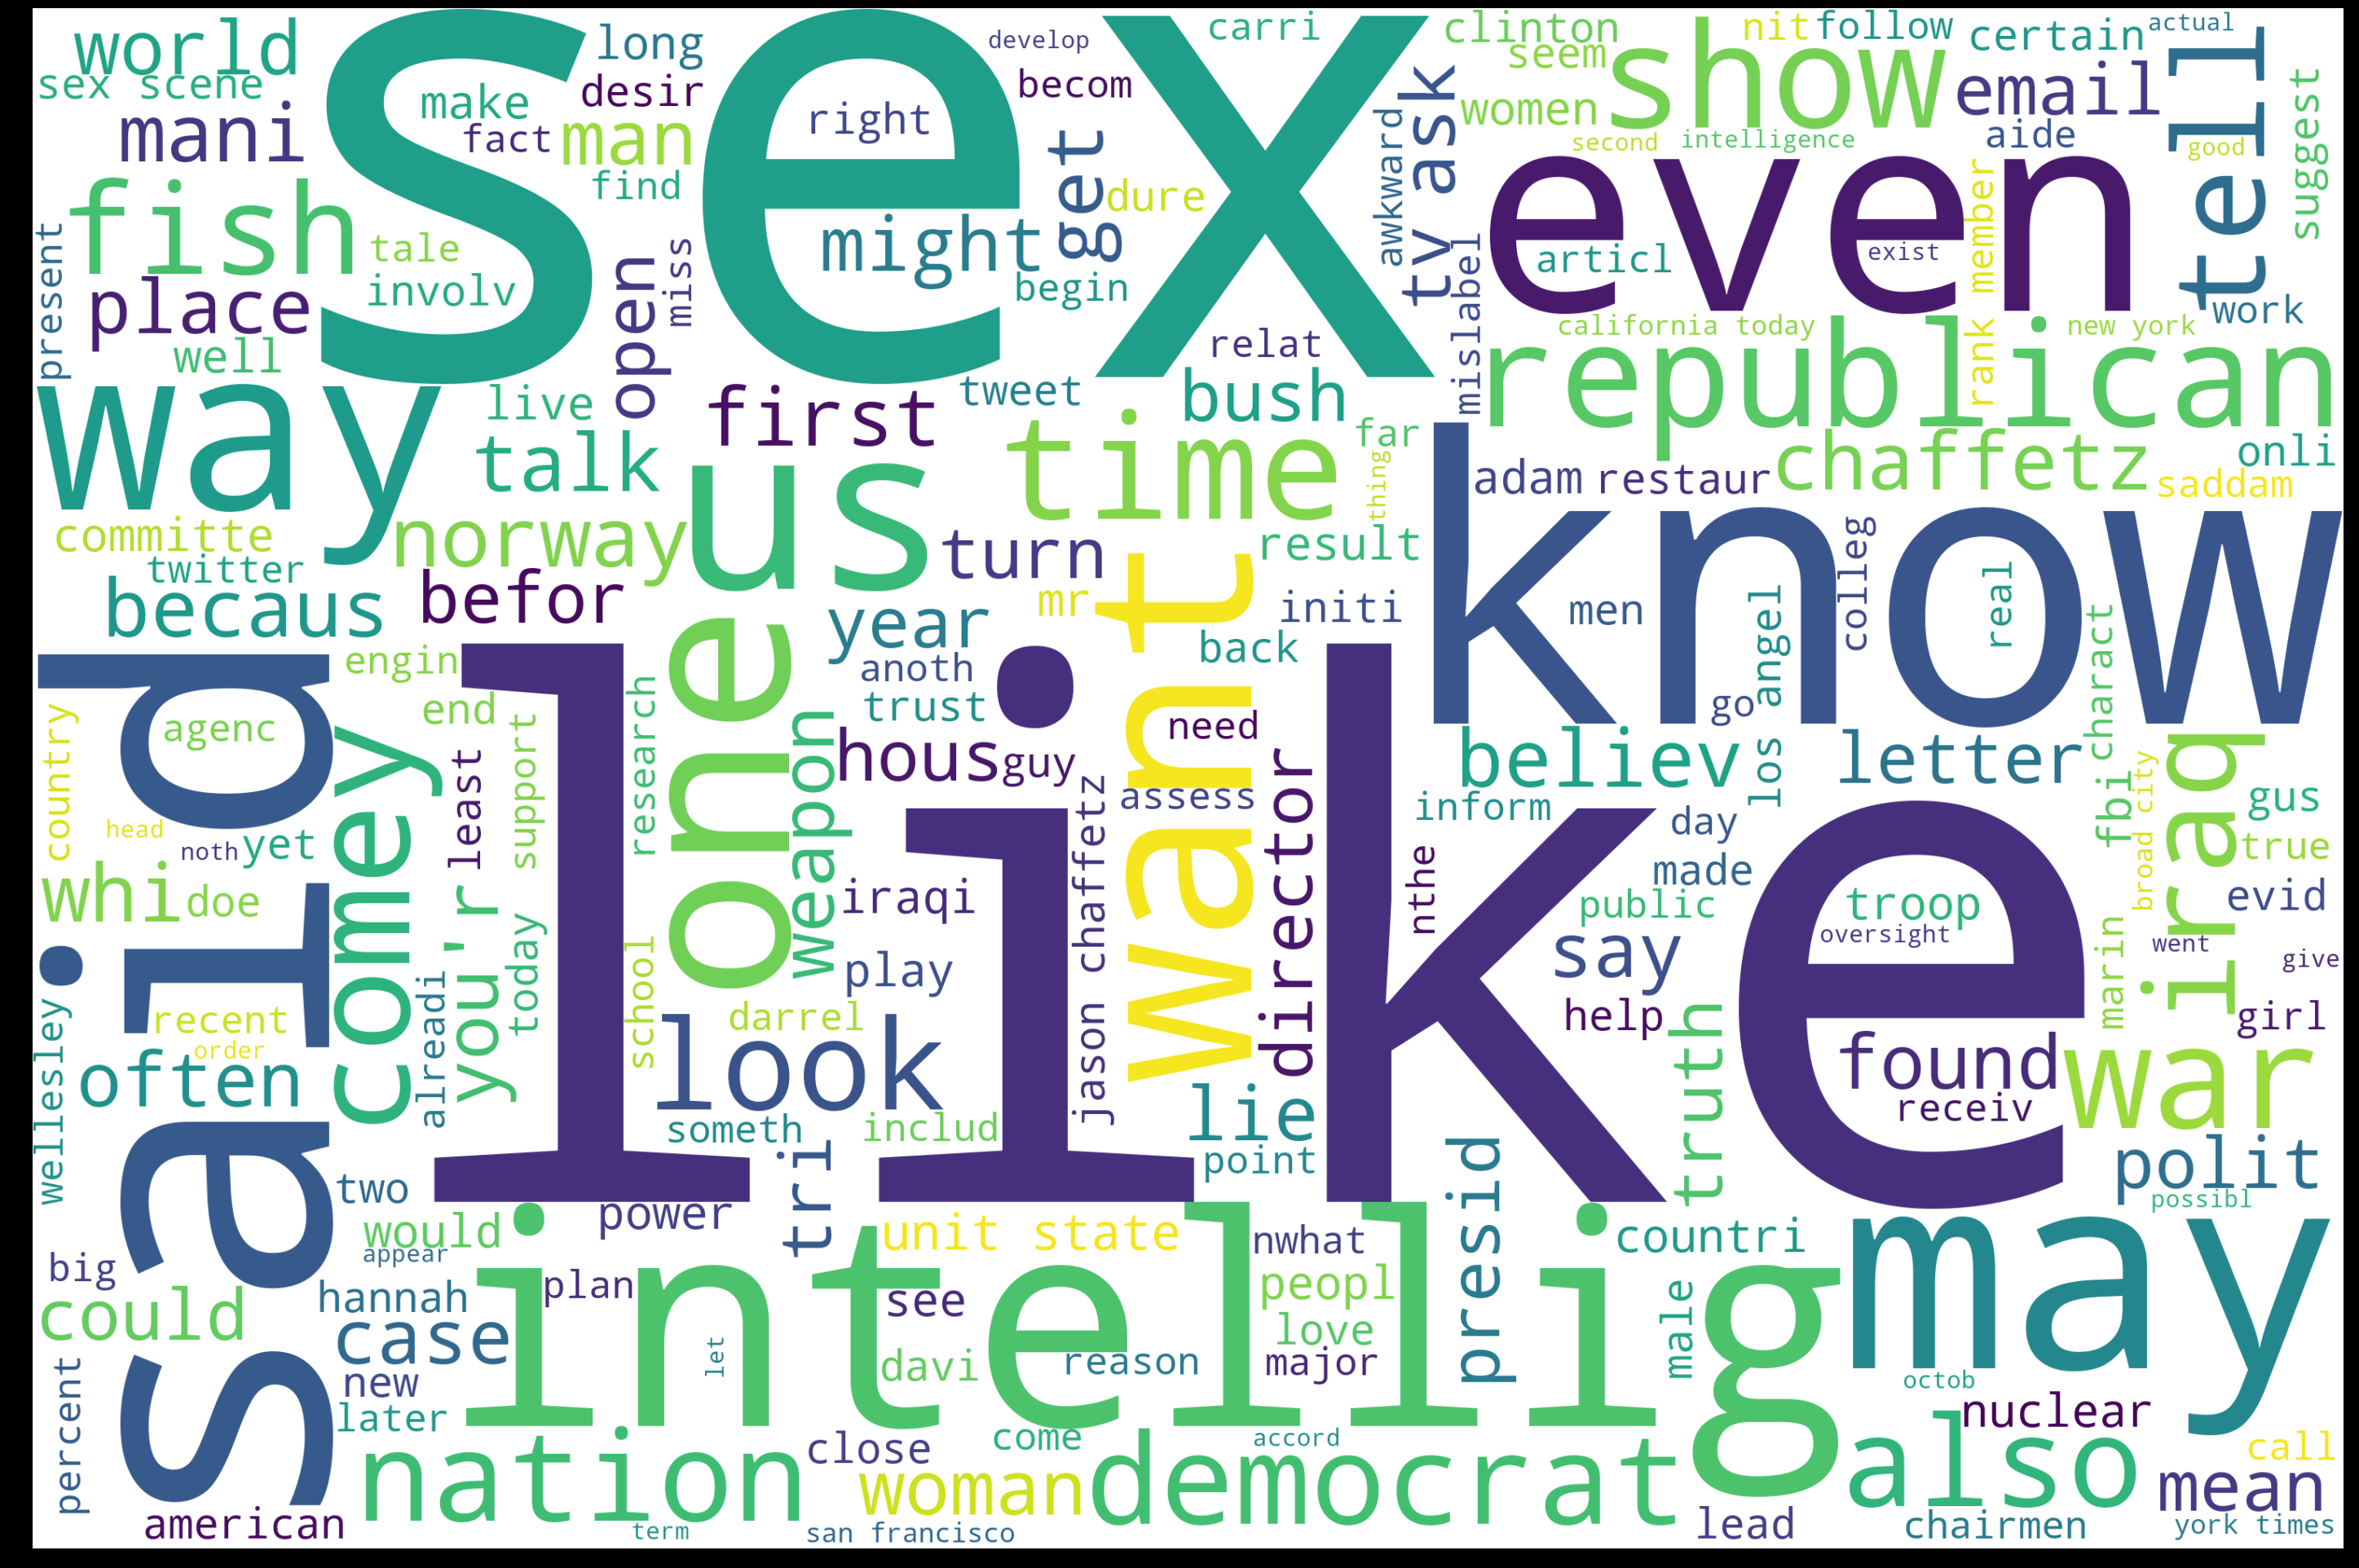

In [25]:
text = df['stemmed_text'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## creating a authors map for further use on the client

In [23]:
authors_df = df[['author', 'author_cat']]
authors_df.head()

author  author_cat
0       Darrell Lucus        2191
1     Daniel J. Flynn        2114
2  Consortiumnews.com        1863
3     Jessica Purkiss        4372
4      Howard Portnoy        3564

In [26]:
authors_df.to_csv('./data/author_cat.csv', index=False)

NameError: name 'authors_df' is not defined

## drop old columns for title, text and author

In [ ]:
# drop the title autor and text
df.drop(['title', 'author', 'text'], axis=1, inplace=True)
df.head()

## creating WordBags with Wordbatch

In [52]:
wb = wordbatch.WordBatch(normalize_text
                         , extractor=(WordBag, {"hash_ngrams": 2,
                                                "hash_ngrams_weights": [0.5, -1.0],
                                                "hash_size": 2 ** 23,
                                                "norm": 'l2',
                                                "tf": 'log',
                                                "idf": 10.0}
                                     )
                         , procs=8
                         , method="serial")

wb.dictionary_freeze = True

## transform the data and merge it into a sparse vector

In [53]:
X_title = wb.transform(df['stemmed_title'])
X_text = wb.transform(df['stemmed_text'])
X_author = df['author_cat'].values
X_author = X_author.reshape(-1, 1)
sparse_merge = hstack((X_title, X_text, X_author)).tocsr()

Normalize text
Extract wordbags
Normalize text
Extract wordbags


In [54]:
sparse_merge.shape

(59594, 16777217)

## split it back to train and test, and split train into train and validation for further crossvalition

In [55]:
X = sparse_merge[:train_size]
X_test = sparse_merge[train_size:]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.05, random_state=100)
d_train = lgb.Dataset(train_X, label=train_y)
d_valid = lgb.Dataset(valid_X, label=valid_y)
watchlist = [d_train, d_valid]

## train the model using lightgbm setting unbalanced = true and setting some feature selection

In [69]:
params = {
        'objective': 'binary',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'feature_fraction': 0.64,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
    
        'max_depth': 9,  # -1 means no limit
#         'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
#         'max_bin': 100,  # Number of bucketed bin for feature values
#         'subsample': 0.7,  # Subsample ratio of the training instance.
#         'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
#         'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
#         'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'is_unbalance': True # because training data is unbalanced 
    }

model = lgb.train(params, train_set=d_train, num_boost_round=6000, valid_sets=watchlist,
                      early_stopping_rounds=200, verbose_eval=1)

[1]	training's binary_logloss: 0.609894	valid_1's binary_logloss: 0.605412
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_logloss: 0.571572	valid_1's binary_logloss: 0.567641
[3]	training's binary_logloss: 0.53593	valid_1's binary_logloss: 0.533766
[4]	training's binary_logloss: 0.506498	valid_1's binary_logloss: 0.505747
[5]	training's binary_logloss: 0.477199	valid_1's binary_logloss: 0.476518
[6]	training's binary_logloss: 0.452367	valid_1's binary_logloss: 0.452325
[7]	training's binary_logloss: 0.429476	valid_1's binary_logloss: 0.429777
[8]	training's binary_logloss: 0.409893	valid_1's binary_logloss: 0.410734
[9]	training's binary_logloss: 0.392695	valid_1's binary_logloss: 0.393961
[10]	training's binary_logloss: 0.377166	valid_1's binary_logloss: 0.378443
[11]	training's binary_logloss: 0.363674	valid_1's binary_logloss: 0.36577
[12]	training's binary_logloss: 0.349547	valid_1's binary_logloss: 0.351409
[13]	training's binary_logloss: 0.33

[108]	training's binary_logloss: 0.0775986	valid_1's binary_logloss: 0.0954625
[109]	training's binary_logloss: 0.0769403	valid_1's binary_logloss: 0.0948333
[110]	training's binary_logloss: 0.0761192	valid_1's binary_logloss: 0.0940741
[111]	training's binary_logloss: 0.0753154	valid_1's binary_logloss: 0.0934944
[112]	training's binary_logloss: 0.0747596	valid_1's binary_logloss: 0.0927618
[113]	training's binary_logloss: 0.0741948	valid_1's binary_logloss: 0.0923576
[114]	training's binary_logloss: 0.0735067	valid_1's binary_logloss: 0.0917102
[115]	training's binary_logloss: 0.0729539	valid_1's binary_logloss: 0.0913187
[116]	training's binary_logloss: 0.0722711	valid_1's binary_logloss: 0.0908207
[117]	training's binary_logloss: 0.0718273	valid_1's binary_logloss: 0.0904638
[118]	training's binary_logloss: 0.07105	valid_1's binary_logloss: 0.0898472
[119]	training's binary_logloss: 0.0704994	valid_1's binary_logloss: 0.0894365
[120]	training's binary_logloss: 0.0698952	valid_1's b

[213]	training's binary_logloss: 0.0343173	valid_1's binary_logloss: 0.0585508
[214]	training's binary_logloss: 0.0340357	valid_1's binary_logloss: 0.0582575
[215]	training's binary_logloss: 0.0337968	valid_1's binary_logloss: 0.0580571
[216]	training's binary_logloss: 0.0335466	valid_1's binary_logloss: 0.058082
[217]	training's binary_logloss: 0.0333204	valid_1's binary_logloss: 0.057887
[218]	training's binary_logloss: 0.032946	valid_1's binary_logloss: 0.0574149
[219]	training's binary_logloss: 0.0327757	valid_1's binary_logloss: 0.057268
[220]	training's binary_logloss: 0.0325458	valid_1's binary_logloss: 0.0569788
[221]	training's binary_logloss: 0.0322978	valid_1's binary_logloss: 0.0568257
[222]	training's binary_logloss: 0.0320437	valid_1's binary_logloss: 0.0567807
[223]	training's binary_logloss: 0.0318274	valid_1's binary_logloss: 0.0566768
[224]	training's binary_logloss: 0.0315661	valid_1's binary_logloss: 0.0565325
[225]	training's binary_logloss: 0.031259	valid_1's bina

[318]	training's binary_logloss: 0.0178002	valid_1's binary_logloss: 0.0439528
[319]	training's binary_logloss: 0.0177096	valid_1's binary_logloss: 0.0438002
[320]	training's binary_logloss: 0.0176216	valid_1's binary_logloss: 0.0437534
[321]	training's binary_logloss: 0.01753	valid_1's binary_logloss: 0.043713
[322]	training's binary_logloss: 0.0174333	valid_1's binary_logloss: 0.0435608
[323]	training's binary_logloss: 0.0173429	valid_1's binary_logloss: 0.0435178
[324]	training's binary_logloss: 0.0172568	valid_1's binary_logloss: 0.0435706
[325]	training's binary_logloss: 0.017174	valid_1's binary_logloss: 0.04352
[326]	training's binary_logloss: 0.0171027	valid_1's binary_logloss: 0.0433833
[327]	training's binary_logloss: 0.0169994	valid_1's binary_logloss: 0.0433019
[328]	training's binary_logloss: 0.0168856	valid_1's binary_logloss: 0.0432652
[329]	training's binary_logloss: 0.0167938	valid_1's binary_logloss: 0.0432295
[330]	training's binary_logloss: 0.0166776	valid_1's binar

[422]	training's binary_logloss: 0.00962618	valid_1's binary_logloss: 0.0361117
[423]	training's binary_logloss: 0.00958189	valid_1's binary_logloss: 0.0360988
[424]	training's binary_logloss: 0.00952223	valid_1's binary_logloss: 0.0359611
[425]	training's binary_logloss: 0.00943577	valid_1's binary_logloss: 0.0358213
[426]	training's binary_logloss: 0.00939967	valid_1's binary_logloss: 0.0357464
[427]	training's binary_logloss: 0.00933552	valid_1's binary_logloss: 0.0357093
[428]	training's binary_logloss: 0.00929524	valid_1's binary_logloss: 0.0356315
[429]	training's binary_logloss: 0.00924875	valid_1's binary_logloss: 0.0356088
[430]	training's binary_logloss: 0.00919579	valid_1's binary_logloss: 0.0356143
[431]	training's binary_logloss: 0.00914386	valid_1's binary_logloss: 0.0355881
[432]	training's binary_logloss: 0.00906311	valid_1's binary_logloss: 0.0355016
[433]	training's binary_logloss: 0.00900933	valid_1's binary_logloss: 0.0355641
[434]	training's binary_logloss: 0.00895

[525]	training's binary_logloss: 0.00524572	valid_1's binary_logloss: 0.0315252
[526]	training's binary_logloss: 0.00522243	valid_1's binary_logloss: 0.0315126
[527]	training's binary_logloss: 0.00520002	valid_1's binary_logloss: 0.0315337
[528]	training's binary_logloss: 0.00518136	valid_1's binary_logloss: 0.0314972
[529]	training's binary_logloss: 0.00516381	valid_1's binary_logloss: 0.0315386
[530]	training's binary_logloss: 0.00514283	valid_1's binary_logloss: 0.0315327
[531]	training's binary_logloss: 0.0051102	valid_1's binary_logloss: 0.0314769
[532]	training's binary_logloss: 0.00508102	valid_1's binary_logloss: 0.031341
[533]	training's binary_logloss: 0.00505758	valid_1's binary_logloss: 0.031354
[534]	training's binary_logloss: 0.00504152	valid_1's binary_logloss: 0.03136
[535]	training's binary_logloss: 0.00501843	valid_1's binary_logloss: 0.0313507
[536]	training's binary_logloss: 0.0049929	valid_1's binary_logloss: 0.0312864
[537]	training's binary_logloss: 0.00496752	va

[628]	training's binary_logloss: 0.0029359	valid_1's binary_logloss: 0.0288798
[629]	training's binary_logloss: 0.00292503	valid_1's binary_logloss: 0.0289032
[630]	training's binary_logloss: 0.00290829	valid_1's binary_logloss: 0.0288968
[631]	training's binary_logloss: 0.00288724	valid_1's binary_logloss: 0.0288466
[632]	training's binary_logloss: 0.00287023	valid_1's binary_logloss: 0.0288714
[633]	training's binary_logloss: 0.00285812	valid_1's binary_logloss: 0.0287641
[634]	training's binary_logloss: 0.00283943	valid_1's binary_logloss: 0.0287644
[635]	training's binary_logloss: 0.00281808	valid_1's binary_logloss: 0.0287889
[636]	training's binary_logloss: 0.00280932	valid_1's binary_logloss: 0.028728
[637]	training's binary_logloss: 0.00279523	valid_1's binary_logloss: 0.028735
[638]	training's binary_logloss: 0.00278053	valid_1's binary_logloss: 0.028714
[639]	training's binary_logloss: 0.00277125	valid_1's binary_logloss: 0.0286664
[640]	training's binary_logloss: 0.00275401	

[731]	training's binary_logloss: 0.00167435	valid_1's binary_logloss: 0.0271663
[732]	training's binary_logloss: 0.00166254	valid_1's binary_logloss: 0.027118
[733]	training's binary_logloss: 0.00165343	valid_1's binary_logloss: 0.0271621
[734]	training's binary_logloss: 0.00164303	valid_1's binary_logloss: 0.027103
[735]	training's binary_logloss: 0.00163107	valid_1's binary_logloss: 0.027063
[736]	training's binary_logloss: 0.00162479	valid_1's binary_logloss: 0.0271173
[737]	training's binary_logloss: 0.00161637	valid_1's binary_logloss: 0.0271311
[738]	training's binary_logloss: 0.00160512	valid_1's binary_logloss: 0.027193
[739]	training's binary_logloss: 0.00159836	valid_1's binary_logloss: 0.0271673
[740]	training's binary_logloss: 0.00159071	valid_1's binary_logloss: 0.0272268
[741]	training's binary_logloss: 0.0015808	valid_1's binary_logloss: 0.0272086
[742]	training's binary_logloss: 0.00157255	valid_1's binary_logloss: 0.0271561
[743]	training's binary_logloss: 0.00156219	v

[834]	training's binary_logloss: 0.000924667	valid_1's binary_logloss: 0.0262929
[835]	training's binary_logloss: 0.000920222	valid_1's binary_logloss: 0.0262427
[836]	training's binary_logloss: 0.000916507	valid_1's binary_logloss: 0.0262501
[837]	training's binary_logloss: 0.000911792	valid_1's binary_logloss: 0.0262511
[838]	training's binary_logloss: 0.000908302	valid_1's binary_logloss: 0.0262761
[839]	training's binary_logloss: 0.00090296	valid_1's binary_logloss: 0.0262916
[840]	training's binary_logloss: 0.000898379	valid_1's binary_logloss: 0.026214
[841]	training's binary_logloss: 0.000894575	valid_1's binary_logloss: 0.026227
[842]	training's binary_logloss: 0.000890011	valid_1's binary_logloss: 0.0261927
[843]	training's binary_logloss: 0.000883289	valid_1's binary_logloss: 0.0262023
[844]	training's binary_logloss: 0.000879504	valid_1's binary_logloss: 0.0261421
[845]	training's binary_logloss: 0.000872272	valid_1's binary_logloss: 0.0261735
[846]	training's binary_logloss

[936]	training's binary_logloss: 0.000527308	valid_1's binary_logloss: 0.0263989
[937]	training's binary_logloss: 0.000525492	valid_1's binary_logloss: 0.0264085
[938]	training's binary_logloss: 0.000523258	valid_1's binary_logloss: 0.0263656
[939]	training's binary_logloss: 0.000518955	valid_1's binary_logloss: 0.0264178
[940]	training's binary_logloss: 0.000516722	valid_1's binary_logloss: 0.0263961
[941]	training's binary_logloss: 0.000512779	valid_1's binary_logloss: 0.0264323
[942]	training's binary_logloss: 0.000510984	valid_1's binary_logloss: 0.0263904
[943]	training's binary_logloss: 0.000508229	valid_1's binary_logloss: 0.026405
[944]	training's binary_logloss: 0.000505221	valid_1's binary_logloss: 0.0264172
[945]	training's binary_logloss: 0.000502139	valid_1's binary_logloss: 0.0263235
[946]	training's binary_logloss: 0.000499719	valid_1's binary_logloss: 0.0263732
[947]	training's binary_logloss: 0.000497789	valid_1's binary_logloss: 0.0264342
[948]	training's binary_loglo

[1038]	training's binary_logloss: 0.000305892	valid_1's binary_logloss: 0.0258142
[1039]	training's binary_logloss: 0.000304599	valid_1's binary_logloss: 0.0258691
[1040]	training's binary_logloss: 0.000303529	valid_1's binary_logloss: 0.0258661
[1041]	training's binary_logloss: 0.000301839	valid_1's binary_logloss: 0.026012
[1042]	training's binary_logloss: 0.000299506	valid_1's binary_logloss: 0.0259795
[1043]	training's binary_logloss: 0.000298315	valid_1's binary_logloss: 0.025955
[1044]	training's binary_logloss: 0.000297008	valid_1's binary_logloss: 0.0259438
[1045]	training's binary_logloss: 0.000295917	valid_1's binary_logloss: 0.0259804
[1046]	training's binary_logloss: 0.000293231	valid_1's binary_logloss: 0.025974
[1047]	training's binary_logloss: 0.000292235	valid_1's binary_logloss: 0.0259958
[1048]	training's binary_logloss: 0.000290433	valid_1's binary_logloss: 0.0259508
[1049]	training's binary_logloss: 0.000289216	valid_1's binary_logloss: 0.0260524
[1050]	training's b

[1139]	training's binary_logloss: 0.000180633	valid_1's binary_logloss: 0.0260825
[1140]	training's binary_logloss: 0.00017924	valid_1's binary_logloss: 0.0260603
[1141]	training's binary_logloss: 0.000178445	valid_1's binary_logloss: 0.0260435
[1142]	training's binary_logloss: 0.000176933	valid_1's binary_logloss: 0.0260185
[1143]	training's binary_logloss: 0.000176069	valid_1's binary_logloss: 0.0260504
[1144]	training's binary_logloss: 0.000175247	valid_1's binary_logloss: 0.0260879
[1145]	training's binary_logloss: 0.000174426	valid_1's binary_logloss: 0.0261243
[1146]	training's binary_logloss: 0.00017358	valid_1's binary_logloss: 0.0260956
[1147]	training's binary_logloss: 0.000172975	valid_1's binary_logloss: 0.0261
[1148]	training's binary_logloss: 0.000172103	valid_1's binary_logloss: 0.026153
[1149]	training's binary_logloss: 0.000171293	valid_1's binary_logloss: 0.0261021
[1150]	training's binary_logloss: 0.000170567	valid_1's binary_logloss: 0.0261461
[1151]	training's bina

[1240]	training's binary_logloss: 0.000104398	valid_1's binary_logloss: 0.0256226
[1241]	training's binary_logloss: 0.00010395	valid_1's binary_logloss: 0.025625
[1242]	training's binary_logloss: 0.000103388	valid_1's binary_logloss: 0.0255957
[1243]	training's binary_logloss: 0.000102644	valid_1's binary_logloss: 0.0256562
[1244]	training's binary_logloss: 0.00010227	valid_1's binary_logloss: 0.0255978
[1245]	training's binary_logloss: 0.000101651	valid_1's binary_logloss: 0.0256432
[1246]	training's binary_logloss: 0.00010118	valid_1's binary_logloss: 0.0256279
[1247]	training's binary_logloss: 0.000100518	valid_1's binary_logloss: 0.0255656
[1248]	training's binary_logloss: 0.000100066	valid_1's binary_logloss: 0.0255856
[1249]	training's binary_logloss: 9.94872e-05	valid_1's binary_logloss: 0.0256074
[1250]	training's binary_logloss: 9.83014e-05	valid_1's binary_logloss: 0.0255717
[1251]	training's binary_logloss: 9.78974e-05	valid_1's binary_logloss: 0.0255383
[1252]	training's bi

[1341]	training's binary_logloss: 6.15999e-05	valid_1's binary_logloss: 0.02603
[1342]	training's binary_logloss: 6.12723e-05	valid_1's binary_logloss: 0.0260445
[1343]	training's binary_logloss: 6.09057e-05	valid_1's binary_logloss: 0.0260127
[1344]	training's binary_logloss: 6.05897e-05	valid_1's binary_logloss: 0.0260298
[1345]	training's binary_logloss: 6.02631e-05	valid_1's binary_logloss: 0.0260255
[1346]	training's binary_logloss: 6.0044e-05	valid_1's binary_logloss: 0.0260228
[1347]	training's binary_logloss: 5.97715e-05	valid_1's binary_logloss: 0.0259763
[1348]	training's binary_logloss: 5.94936e-05	valid_1's binary_logloss: 0.0259692
[1349]	training's binary_logloss: 5.91546e-05	valid_1's binary_logloss: 0.0259156
[1350]	training's binary_logloss: 5.88817e-05	valid_1's binary_logloss: 0.0259668
[1351]	training's binary_logloss: 5.84962e-05	valid_1's binary_logloss: 0.0259897
[1352]	training's binary_logloss: 5.81528e-05	valid_1's binary_logloss: 0.0259805
[1353]	training's b

[1442]	training's binary_logloss: 3.63322e-05	valid_1's binary_logloss: 0.0264876
[1443]	training's binary_logloss: 3.6113e-05	valid_1's binary_logloss: 0.0264636
[1444]	training's binary_logloss: 3.59098e-05	valid_1's binary_logloss: 0.0264315
[1445]	training's binary_logloss: 3.57468e-05	valid_1's binary_logloss: 0.0264323
[1446]	training's binary_logloss: 3.55696e-05	valid_1's binary_logloss: 0.0265376
[1447]	training's binary_logloss: 3.5389e-05	valid_1's binary_logloss: 0.0265281
[1448]	training's binary_logloss: 3.51204e-05	valid_1's binary_logloss: 0.0264875
[1449]	training's binary_logloss: 3.49043e-05	valid_1's binary_logloss: 0.0264808
[1450]	training's binary_logloss: 3.47117e-05	valid_1's binary_logloss: 0.0264993
[1451]	training's binary_logloss: 3.44615e-05	valid_1's binary_logloss: 0.0264772
[1452]	training's binary_logloss: 3.42534e-05	valid_1's binary_logloss: 0.0264561
[1453]	training's binary_logloss: 3.41365e-05	valid_1's binary_logloss: 0.0264576
[1454]	training's 

## checking the results of the validation

In [62]:
preds = model.predict(valid_X)
print("LGB dev f1_score:", f1_score(valid_y, np.round(preds)))
print("LGB dev accuracy_score:", accuracy_score(valid_y, np.round(preds)))
print("LGB dev recall_score:", recall_score(valid_y, np.round(preds)))
print("LGB dev precision_score:", precision_score(valid_y, np.round(preds)))

LGB dev f1_score: 0.9909090909090909
LGB dev accuracy_score: 0.9933823529411765
LGB dev recall_score: 0.9919110212335692
LGB dev precision_score: 0.9899091826437941


## saving the lightgmb model for use on the deployment API

In [63]:
print('Saving model...')
# save model to file
if not os.path.exists('data/models/'):
    os.makedirs('data/models/')

model.save_model('data/models/lgb_model_best_iter_5.txt', num_iteration=model.best_iteration)
print('Model Saved')

Saving model...
Model Saved


## saving the wordbatch transformation to be used at the deployment API

In [64]:
print("Saving wb model")
with open('data/models/wb_transform_5.pkl', 'wb') as model_file:
    pkl.dump(wb, model_file, protocol=2)
print('Model Saved')

Saving wb model
Model Saved


## saving the submission for test in Kaggle 

In [65]:
y_hat = model.predict(X_test)
pred = pd.DataFrame(np.round(y_hat).astype(int), columns=['label'])
pred['id'] = test_ids
pred.to_csv('data/kaggle/submission_lgb_simple_5.csv', index=False)
print('Kaggle Submission Saved to data/kaggle/')

Kaggle Submission Saved to data/kaggle/
